In [1]:
setwd('/import/oa/')

In [2]:
count = read.table('./final.count.txt',header =T,sep = '\t')

In [3]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
colnames(count)

[1] "gene_name"    "Day0_1"       "Day0_2"       "Day0_3"       "Day1_1"      
 [6] "Day1_2"       "Day1_3"       "Day3_1"       "Day3_2"       "Day3_3"      
[11] "cited2_con_1" "cited2_con_2" "cited2_con_3" "cited2_ko_1"  "cited2_ko_2"

In [5]:
count1 = count[!duplicated(count$gene_name),c(1:4,8:10)] %>%  na.omit()

In [6]:

count = count1 %>%  tibble::remove_rownames() %>% tibble::column_to_rownames(.,'gene_name')

In [7]:
group = c(rep('Day0',3),rep('Day3',3))

In [8]:
group = factor(group,levels = c('Day0','Day3'))

In [9]:
expr1 = count

In [10]:
library(limma)
design <- model.matrix(~0+group)

Warning message:
"package 'limma' was built under R version 4.2.3"


In [11]:
design

,groupDay0,groupDay3
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


In [12]:
levels(group)

[1] "Day0" "Day3"

In [13]:
rownames(design) = colnames(expr1)
colnames(design) <- levels(group)

In [14]:
library(edgeR)

Warning message:
"package 'edgeR' was built under R version 4.2.3"


In [15]:
DGElist <- DGEList(counts = expr1, group = group)
keep_gene <- rowSums(cpm(DGElist) > 1) >= 1
table(keep_gene)
DGElist <- DGElist[keep_gene, ,keep.lib.sizes =FALSE]

keep_gene
FALSE  TRUE 
19889 15875 

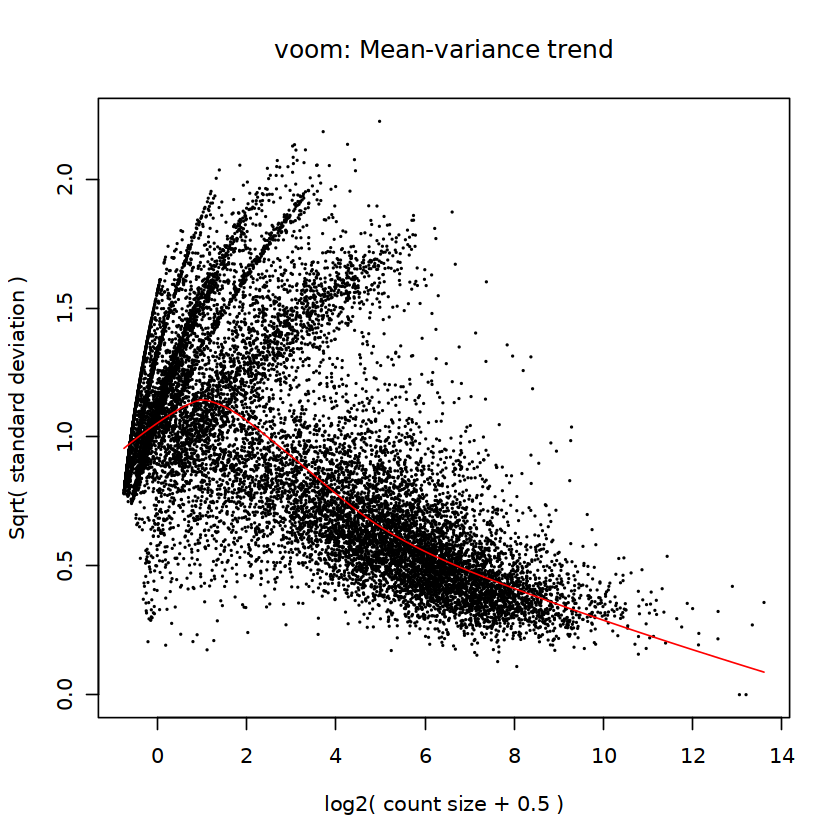

In [16]:
DGElist <- calcNormFactors( DGElist )
v <- voom(DGElist, design, plot = TRUE, normalize = "quantile")
fit <- lmFit(v, design)

In [17]:
cont.matrix <- makeContrasts(contrasts = c('Day3-Day0'), levels = design)

In [18]:
design

,Day0,Day3
Day0_1,1,0
Day0_2,1,0
Day0_3,1,0
Day3_1,0,1
Day3_2,0,1
Day3_3,0,1


In [19]:
fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2)

In [20]:
nrDEG_limma_voom = topTable(fit2, coef = 'Day3-Day0', n = Inf)
nrDEG_limma_voom = na.omit(nrDEG_limma_voom)
head(nrDEG_limma_voom)
library(dplyr)
res<-cbind(rownames(nrDEG_limma_voom),nrDEG_limma_voom)
res_1<-res %>% dplyr::filter((logFC>1 | logFC < (-1)) & adj.P.Val < 0.05)
colnames(res_1)[1]<-"Symbol"

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC005537,-1.8174874,11.038468,-45.25245,3.262640e-10,2.589720e-06,14.46430
Ftl1,-0.3162891,13.199071,-45.88867,2.947369e-10,2.589720e-06,13.40585
Fosl2,1.9184750,9.341885,29.72532,6.912549e-09,2.193399e-05,11.41384
Atp6v1b2,1.6812789,10.787593,29.99638,6.472337e-09,2.193399e-05,11.31822
Atp5f1b,0.9880220,10.959970,28.44532,9.509313e-09,2.193399e-05,10.80688
Ctsd,-0.6848985,12.132713,-28.37891,9.671682e-09,2.193399e-05,10.28048


In [21]:
write.csv(res,file = 'bulk.day3.vs.day0.csv')

### 蛋白数据

In [22]:
prot = read.table('./protein2.txt',header =T,sep = '\t')

In [23]:
head(prot,2)

,gene_name,day30,day30.p,day30.EF
,<chr>,<dbl>,<dbl>,<dbl>
1,Plec,2.270731,5.519790e-09,1.262254
2,Eno1,1.777703,3.354033e-02,1.690370


In [24]:
library(VennDiagram)
library(RColorBrewer)

Loading required package: grid

Loading required package: futile.logger

Warning message:
"package 'futile.logger' was built under R version 4.2.3"


In [31]:
venn_ploy <- venn.diagram(
  x = list(
    rna = rownames(res_1),
    prot = prot$gene_name
    #C = sample(genes, 128)
  ),
  filename = NULL,
  fill = brewer.pal(7, "Set1")[2:3]
)

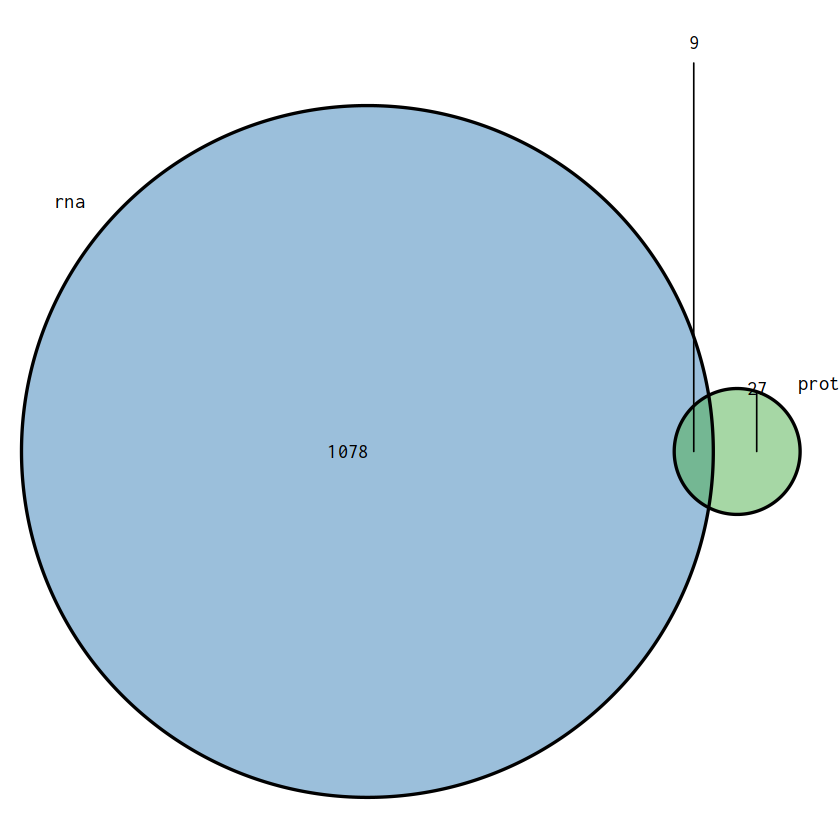

In [32]:
grid.draw(venn_ploy)

In [33]:
pdf('day3.vs.day0.venn.prot.pdf')
grid.draw(venn_ploy)
dev.off()

png 
  2

In [34]:
merge(res_1,prot,by.x = 'Symbol',by.y = 'gene_name')

Symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,day30,day30.p,day30.EF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Acp5,7.611979,4.617619,6.566309,2.618623e-04,6.375865e-03,0.5487289,45.1545715,5.336049e-03,5.279625
Anxa1,2.111434,8.973417,17.094689,3.721386e-07,1.429012e-04,7.3725888,2.8050311,1.480740e-08,1.259032
Atox1,1.262504,6.784255,6.967966,1.790609e-04,5.004563e-03,1.1498480,1.4208940,4.983915e-02,1.420067
Atp6v1a,1.234396,8.856965,8.696104,4.153458e-05,2.004138e-03,2.2430845,1.3610470,2.986691e-02,1.307680
Atp6v1b2,1.681279,10.787593,29.996380,6.472337e-09,2.193399e-05,11.3182213,1.7318259,1.437655e-02,1.524643
Ckb,2.639486,10.385332,23.951202,3.298228e-08,3.694346e-05,9.7283045,3.3752880,8.951612e-03,2.188095
F13a1,-10.975620,4.501644,-9.384114,2.481379e-05,1.418691e-03,2.7884868,0.1931122,6.359630e-04,2.155196
Idh3a,2.777731,5.868009,4.542149,2.390333e-03,3.077127e-02,-1.3239947,2.2927699,1.614607e-02,1.711487
S100a9,-2.417359,7.844780,-15.058855,9.180732e-07,2.025651e-04,6.5532972,0.1153614,3.256692e-03,1.701711


In [37]:
over = merge(res_1,prot,by.x = 'Symbol',by.y = 'gene_name')
write.csv(over,file = 'bulkday3.vs.day0.venn.csv',quote =F )